In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets:

In [ ]:
# from google.colab import files
# uploaded = files.upload()
from google.colab import drive
drive.mount('/content/drive')

# this notebook is run on Google Colab & Google Drive, may need to modify the file path if necessary.
train_file_path = '/content/drive/My Drive/AML Project/train.csv'
misconception_file_path = '/content/drive/My Drive/AML Project/misconception_mapping.csv'
test_file_path = '/content/drive/My Drive/AML Project/test.csv'
sample_submission_path = '/content/drive/My Drive/AML Project/sample_submission.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**The dataset contains 4 files as follows:**

**`[train/test].csv`**

- `QuestionId` - Unique question identifier (int).

- `ConstructId` - Unique construct identifier (int) .

- `ConstructName` - Most granular level of knowledge related to question (str).

- `CorrectAnswer` - A, B, C or D (char).

- `SubjectId` - Unique subject identifier (int).

- `SubjectName` - More general context than the construct (str).

- `QuestionText` - Question text extracted from the question image using human-in-the-loop OCR (str) .

- `Answer[A/B/C/D]Text` - Answer option A text extracted from the question image using human-in-the-loop OCR (str).

- `Misconception[A/B/C/D]Id` - Unique misconception identifier (int). Ground truth labels in train.csv; your task is to predict these labels for test.csv.

**`misconception_mapping.csv`** - maps `MisconceptionId` to its `MisconceptionName`

**`sample_submission.csv`** - A submission file in the correct format.

`QuestionId_Answer` - Each question has three incorrect answers for which need you predict the MisconceptionId.

`MisconceptionId` - You can predict up to 25 values, space delimited.

In [3]:
# Load dataset
train_data = pd.read_csv(train_file_path)

# Check data dimension
print(f'Shape of the train data: {train_data.shape}\n')

Shape of the train data: (1869, 15)



In [4]:
# Load dataset
misconception_map_data = pd.read_csv(misconception_file_path)

# Check data dimension
print(f'Shape of the misconception map data: {misconception_map_data.shape}\n')

# # Check for missing values
# print(misconception_map_data.isnull().sum())

# # Display the dataframe to check if it's loaded correctly
# misconception_map_data.head()

Shape of the misconception map data: (2587, 2)



In [5]:
# Load dataset
test_data = pd.read_csv(test_file_path)

# Check data dimension
print(f'Shape of the test data: {test_data.shape}\n')

# # Check for missing values
# print(test_data.isnull().sum())

# # Display the dataframe to check if it's loaded correctly
# test_data.head()

Shape of the test data: (3, 11)



In [6]:
# Load dataset
sample_submission_data = pd.read_csv(sample_submission_path)

# Check data dimension
print(f'Shape of the sample submission data: {sample_submission_data.shape}\n')

# # Check for missing values
# print(sample_submission_data.isnull().sum())

# # Display the dataframe to check if it's loaded correctly
# sample_submission_data.head()

Shape of the sample submission data: (9, 2)



#  **Interactive Math Question Display**

Below we use HTML-like interactive display to visualize what does the questions look like, showing ConstructName, SubjectName, Question_text, Answer_text, CorrectAnswer, and MisconceptionName.

In [7]:
# !pip install -qq pylatexenc
from IPython.display import display, HTML
from pylatexenc.latex2text import LatexNodes2Text

# Misconception ID mapping table
misTable = {row['MisconceptionId']: row['MisconceptionName'] for _, row in misconception_map_data.iterrows()}

# take a look at misTable
for i, (key, value) in enumerate(misTable.items()):
    if i >= 10:
        break
    print(f"Misconception ID: {key}, Misconception Name: {value}")

Misconception ID: 0, Misconception Name: Does not know that angles in a triangle sum to 180 degrees
Misconception ID: 1, Misconception Name: Uses dividing fractions method for multiplying fractions
Misconception ID: 2, Misconception Name: Believes there are 100 degrees in a full turn
Misconception ID: 3, Misconception Name: Thinks a quadratic without a non variable term, can not be factorised
Misconception ID: 4, Misconception Name: Believes addition of terms and powers of terms are equivalent e.g. a + c = a^c
Misconception ID: 5, Misconception Name: When measuring a reflex angle, gives the acute or obtuse angle that sums to 360 instead
Misconception ID: 6, Misconception Name: Can identify the multiplier used to form an equivalent fraction but does not apply to the numerator
Misconception ID: 7, Misconception Name: Believes gradient = change in y
Misconception ID: 8, Misconception Name: Student thinks that any two angles along a straight line are equal
Misconception ID: 9, Misconceptio

In [8]:
# Function to map Misconception IDs to names, with NaN handling
def map_misconception_id(value, misTable):
    # Check for NaN values to avoid mapping errors
    if pd.isna(value):
        return "No misconception/NaN"
    # Retrieve misconception name by ID, or return default if ID is missing
    return misTable.get(int(value), "Unknown Misconception")

# Main function to generate and display question HTML with MathJax support
def generate_question_html(data, index, lat2text=1):
    global misTable

    # Retrieve question text (LaTeX text should be retained for MathJax rendering)
    question = data.iloc[index].QuestionText

    # Collect options (A, B, C, D) from the DataFrame
    options = [data[f'Answer{i}Text'].iloc[index] for i in ['A', 'B', 'C', 'D']]

    # Fetch other necessary fields
    correct_answer = data.iloc[index].CorrectAnswer
    construct_name = data.iloc[index].ConstructName
    subject_name = data.iloc[index].SubjectName

    # Map each misconception ID to its corresponding name using the mapping function
    misconception_a = map_misconception_id(data.iloc[index].MisconceptionAId, misTable)
    misconception_b = map_misconception_id(data.iloc[index].MisconceptionBId, misTable)
    misconception_c = map_misconception_id(data.iloc[index].MisconceptionCId, misTable)
    misconception_d = map_misconception_id(data.iloc[index].MisconceptionDId, misTable)

    # Begin constructing the HTML layout with MathJax script included
    html = """
    <script type="text/javascript" async
      src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML">
    </script>
    """
    html += f"""
    <div style='font-family: Arial, sans-serif; border: 2px solid #D4A373; padding: 15px; border-radius: 10px; width: 60%; margin: 0 auto; background-color: #F5F0E1;'>
        <p style='font-size: 16px; color: #C87D6D;'><strong>Construct Name:</strong> {construct_name}</p>
        <p style='font-size: 16px; color: #C87D6D;'><strong>Subject Name:</strong> {subject_name}</p>
        <hr style='border: 1px solid #D4A373; margin: 10px 0;'>
        <p style='font-size: 18px; font-weight: bold; color: #A45D5D;'>Problem:</p>
        <p style='font-size: 20px; color: #333; font-weight: bold;'>{question}</p>
        <ul style='list-style-type: none; padding: 0;'>
    """

    # Define option labels and add each option to HTML, ensuring LaTeX notation remains
    option_letters = ['A', 'B', 'C', 'D']
    for i, option in enumerate(options):
        html += f"""
        <li style='background-color: #E8DAB2; padding: 10px; margin: 5px 0; border-radius: 5px;'>
            <span style='font-weight: bold; color: #8E5E44;'>{option_letters[i]}.</span> <span>{option}</span>
        </li>
        """

    # Close the options list, add correct answer and misconceptions
    html += f"""
        </ul>
        <p style='font-size: 18px; font-weight: bold; color: #679436;'>Correct answer: {correct_answer}</p>
        <hr style='border: 1px solid #D4A373; margin: 20px 0;'>
        <p style='font-size: 16px; color: #555;'><strong>Misconception A:</strong> {misconception_a}</p>
        <p style='font-size: 16px; color: #555;'><strong>Misconception B:</strong> {misconception_b}</p>
        <p style='font-size: 16px; color: #555;'><strong>Misconception C:</strong> {misconception_c}</p>
        <p style='font-size: 16px; color: #555;'><strong>Misconception D:</strong> {misconception_d}</p>
    </div>
    """

    # Render the HTML in the notebook
    display(HTML(html))

In [9]:
# Illustration using QuestionId=0
generate_question_html(train_data, index=0, lat2text=1)
# the content matches what's in the dataset!

In [10]:
# Illustration using QuestionId=1
generate_question_html(train_data, index=1, lat2text=1)

In [11]:
# Illustration using QuestionId=24
generate_question_html(train_data, index=24, lat2text=1)

# **Data Exploration:**

We then dive into exploratory data analysis & visualization. We'll look at train, test, and misconception mapping datasets only. Since sample submission is by submission use, we will not analyze it.

# **train.csv**

In [12]:
# Check data information
print(f'Shape of the train data: {train_data.shape}\n')
display(train_data.head(5))
# Check for missing values
print(train_data.isnull().sum())

Shape of the train data: (1869, 15)



,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText,MisconceptionAId,MisconceptionBId,MisconceptionCId,MisconceptionDId
0,0,856,Use the order of operations to carry out calcu...,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets,NaN,NaN,NaN,1672.0
1,1,1612,Simplify an algebraic fraction by factorising ...,1077,Simplifying Algebraic Fractions,D,"Simplify the following, if possible: \( \frac{...",\( m+1 \),\( m+2 \),\( m-1 \),Does not simplify,2142.0,143.0,2142.0,NaN
2,2,2774,Calculate the range from a list of data,339,Range and Interquartile Range from a List of Data,B,Tom and Katie are discussing the \( 5 \) plant...,Only\nTom,Only\nKatie,Both Tom and Katie,Neither is correct,1287.0,NaN,1287.0,1073.0
3,3,2377,Recall and use the intersecting diagonals prop...,88,Properties of Quadrilaterals,C,The angles highlighted on this rectangle with ...,acute,obtuse,\( 90^{\circ} \),Not enough information,1180.0,1180.0,NaN,1180.0
4,4,3387,Substitute positive integer values into formul...,67,Substitution into Formula,A,The equation \( f=3 r^{2}+3 \) is used to find...,\( 30 \),\( 27 \),\( 51 \),\( 24 \),NaN,NaN,NaN,1818.0


QuestionId            0
ConstructId           0
ConstructName         0
SubjectId             0
SubjectName           0
CorrectAnswer         0
QuestionText          0
AnswerAText           0
AnswerBText           0
AnswerCText           0
AnswerDText           0
MisconceptionAId    734
MisconceptionBId    751
MisconceptionCId    789
MisconceptionDId    832
dtype: int64


In [13]:
display(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1869 entries, 0 to 1868
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   QuestionId        1869 non-null   int64  
 1   ConstructId       1869 non-null   int64  
 2   ConstructName     1869 non-null   object 
 3   SubjectId         1869 non-null   int64  
 4   SubjectName       1869 non-null   object 
 5   CorrectAnswer     1869 non-null   object 
 6   QuestionText      1869 non-null   object 
 7   AnswerAText       1869 non-null   object 
 8   AnswerBText       1869 non-null   object 
 9   AnswerCText       1869 non-null   object 
 10  AnswerDText       1869 non-null   object 
 11  MisconceptionAId  1135 non-null   float64
 12  MisconceptionBId  1118 non-null   float64
 13  MisconceptionCId  1080 non-null   float64
 14  MisconceptionDId  1037 non-null   float64
dtypes: float64(4), int64(3), object(8)
memory usage: 219.1+ KB


None

## **CONSTRUCTS**

In [14]:
# Get counts and percentages of each unique construct in "ConstructName"
construct_names = train_data["ConstructName"].value_counts(dropna=False).reset_index()
construct_names.columns = ["ConstructName", "count"]

# Calculate the percentage
construct_names["Percentage"] = (construct_names["count"] / construct_names["count"].sum() * 100).round(2)

# Display the table
display(construct_names)

,ConstructName,count,Percentage
0,Calculate the square of a number,14,0.75
1,"Solve two-step linear equations, with the vari...",13,0.70
2,Factorise a quadratic expression in the form x...,13,0.70
3,Use the order of operations to carry out calcu...,12,0.64
4,Identify the order of rotational symmetry of a...,12,0.64
...,...,...,...
752,Shade percentages of a shape where the percent...,1,0.05
753,"Solve three or more step linear equations, wit...",1,0.05
754,"Know the bearings of North-West, North-East, S...",1,0.05
755,"Given a gradient, state the gradient of a line...",1,0.05


In [15]:
# Filter constructs that appear only once and get their count
number_of_single_occurrence_construct = (construct_names["count"] == 1).sum()

# Get the total number of distinct constructs
total_distinct_constructs = construct_names.shape[0]

# Print the results
print(f"Number of constructs that appear only once: {number_of_single_occurrence_construct}")
print(f"Total number of distinct constructs: {total_distinct_constructs}")

Number of constructs that appear only once: 302
Total number of distinct constructs: 757


<ipython-input-16-becc251f5a4b>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_30_constructs.index, x=top_30_constructs.values, palette="viridis")


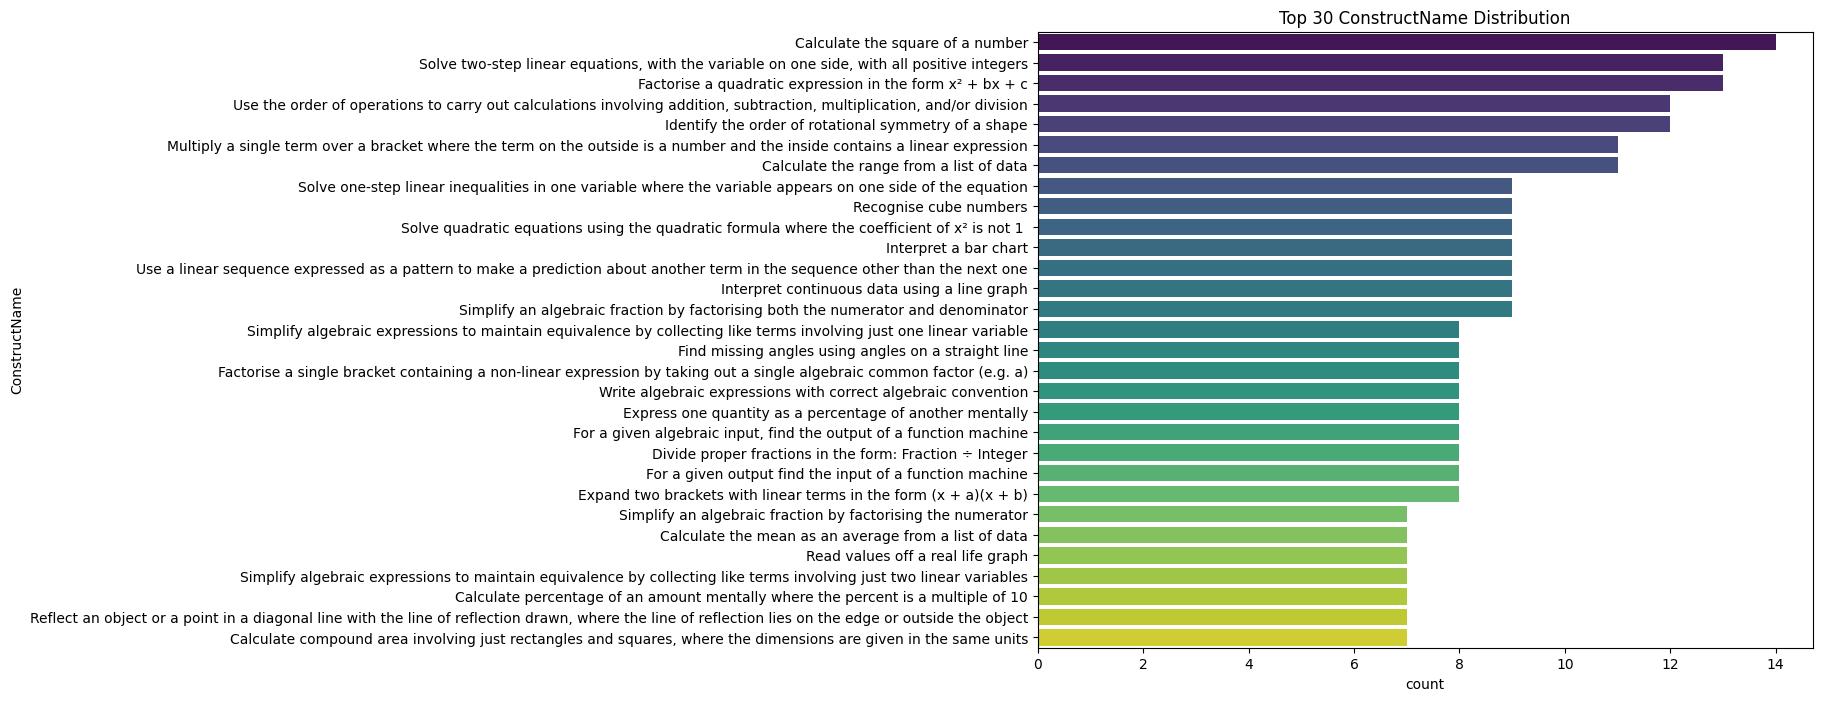

In [16]:
# Frequency distribution of the top 30 ConstructNames
construct_counts = train_data['ConstructName'].value_counts()
top_30_constructs = construct_counts.nlargest(30)
plt.figure(figsize=(10, 8))
sns.barplot(y=top_30_constructs.index, x=top_30_constructs.values, palette="viridis")
plt.title("Top 30 ConstructName Distribution")
plt.xlabel("count")
plt.ylabel("ConstructName")
plt.show()

<ipython-input-17-79bed97fa2d0>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_50_constructs.index, x=cumulative_percentage, palette="viridis")


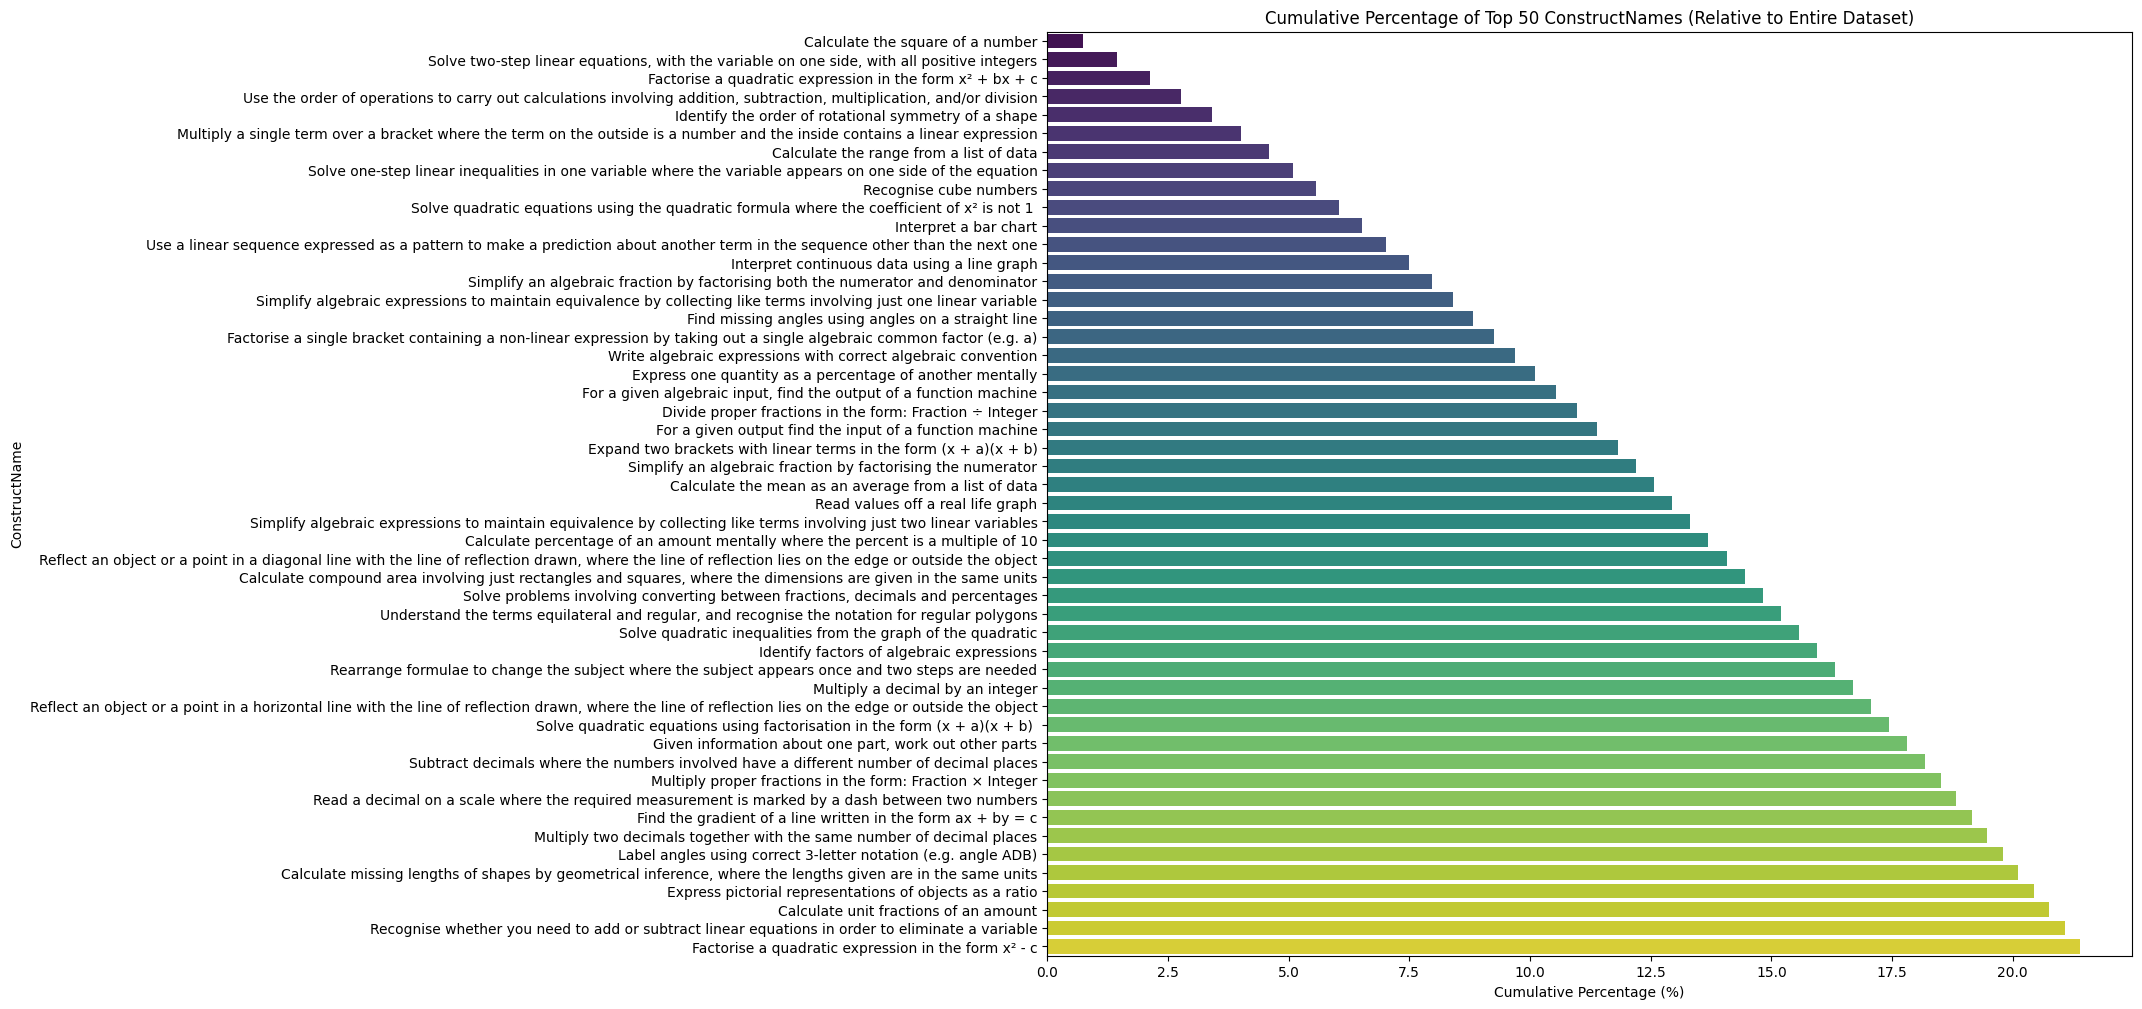

In [17]:
# Calculate cumulative percentage relative to the entire dataset
top_50_constructs = construct_counts.nlargest(50)

cumulative_percentage = top_50_constructs.cumsum() / construct_counts.sum() * 100

# Plot the cumulative percentage for the top 50 ConstructNames
plt.figure(figsize=(14, 12))
sns.barplot(y=top_50_constructs.index, x=cumulative_percentage, palette="viridis")
plt.title("Cumulative Percentage of Top 50 ConstructNames (Relative to Entire Dataset)")
plt.xlabel("Cumulative Percentage (%)")
plt.ylabel("ConstructName")
plt.show()

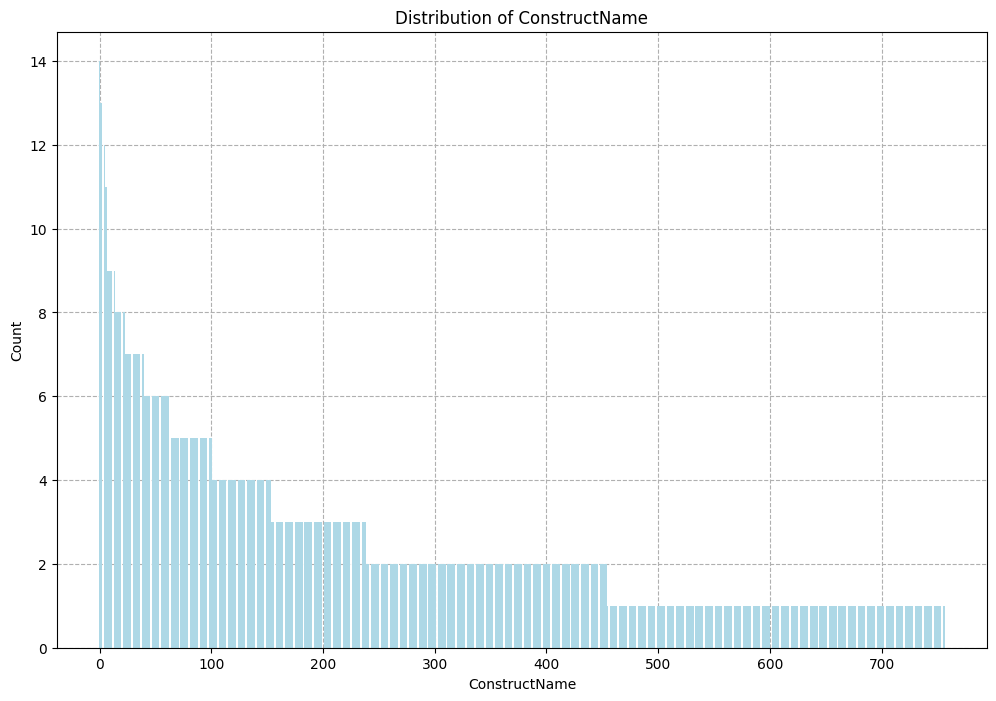

In [18]:
# overall frequency plot
plt.figure(figsize=(12,8))
plt.bar(construct_names.index, construct_counts, color='lightblue', zorder=2)
plt.xlabel('ConstructName')
plt.ylabel('Count')
plt.title('Distribution of ConstructName')
plt.grid(ls='--')
plt.show()

## **SUBJECTS**

In [19]:
# Get counts and percentages of each unique subject in "SubjectName"
subject_names = train_data["SubjectName"].value_counts(dropna=False).reset_index()
subject_names.columns = ["SubjectName", "count"]

# Calculate the percentage
subject_names["Percentage"] = (subject_names["count"] / subject_names["count"].sum() * 100).round(2)

# Display the table
display(subject_names)

,SubjectName,count,Percentage
0,Linear Equations,53,2.84
1,Linear Sequences (nth term),44,2.35
2,BIDMAS,37,1.98
3,Quadratic Equations,36,1.93
4,Area of Simple Shapes,36,1.93
...,...,...,...
158,Types of Data and Questionnaires,1,0.05
159,Co-ordinate Geometry with Straight Lines,1,0.05
160,Percentage Increase and Decrease,1,0.05
161,Averages and Range from Grouped Data,1,0.05


In [20]:
# Filter Subject that appear only once and get their count
number_of_single_occurrence_subject = (subject_names["count"] == 1).sum()

# Get the total number of distinct constructs
total_distinct_subjects = subject_names.shape[0]

# Print the results
print(f"Number of subjects that appear only once: {number_of_single_occurrence_subject}")
print(f"Total number of distinct subjects: {total_distinct_subjects}")

Number of subjects that appear only once: 15
Total number of distinct subjects: 163


<ipython-input-21-e24e88c4c8ea>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_20_subjects.index, x=top_20_subjects.values, palette="viridis")


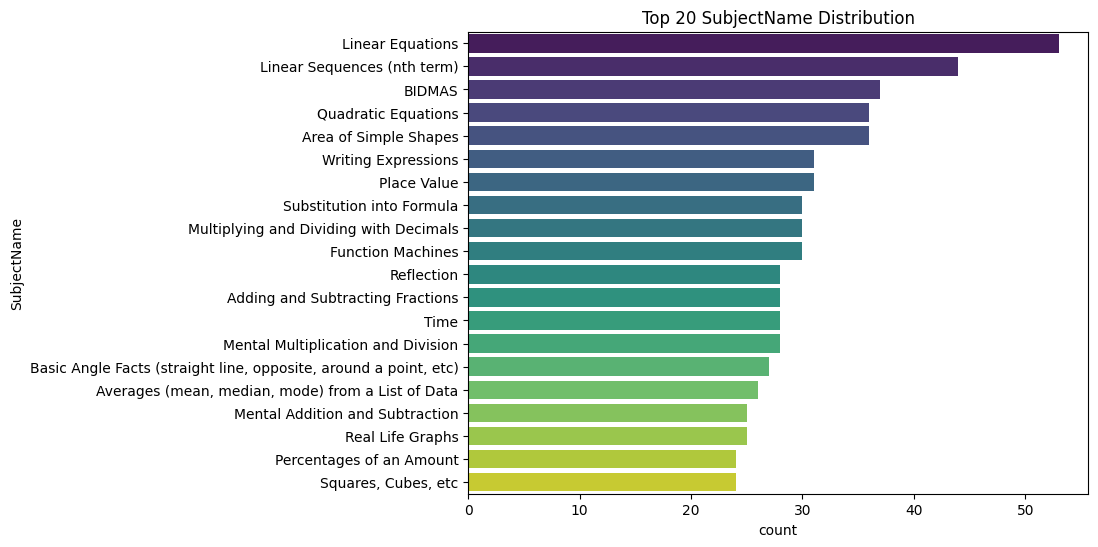

In [21]:
# Frequency distribution of the top 20 SubjectNames
subject_counts = train_data['SubjectName'].value_counts()
top_20_subjects = subject_counts.nlargest(20)
plt.figure(figsize=(8, 6))
sns.barplot(y=top_20_subjects.index, x=top_20_subjects.values, palette="viridis")
plt.title("Top 20 SubjectName Distribution")
plt.xlabel("count")
plt.ylabel("SubjectName")
plt.show()

<ipython-input-22-d4fb2a990565>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_20_subjects.index, x=cumulative_percentage, palette="viridis")


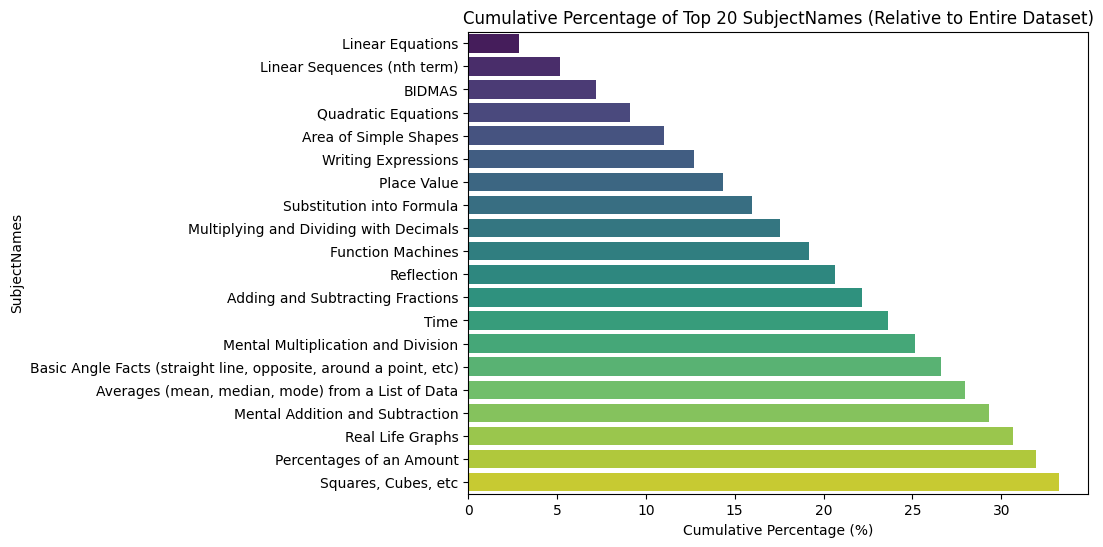

In [22]:
# Calculate cumulative percentage relative to the entire dataset
cumulative_percentage = top_20_subjects.cumsum() / subject_counts.sum() * 100

# Plot the cumulative percentage for the top 20 SubjectNames
plt.figure(figsize=(8, 6))
sns.barplot(y=top_20_subjects.index, x=cumulative_percentage, palette="viridis")
plt.title("Cumulative Percentage of Top 20 SubjectNames (Relative to Entire Dataset)")
plt.xlabel("Cumulative Percentage (%)")
plt.ylabel("SubjectNames")
plt.show()

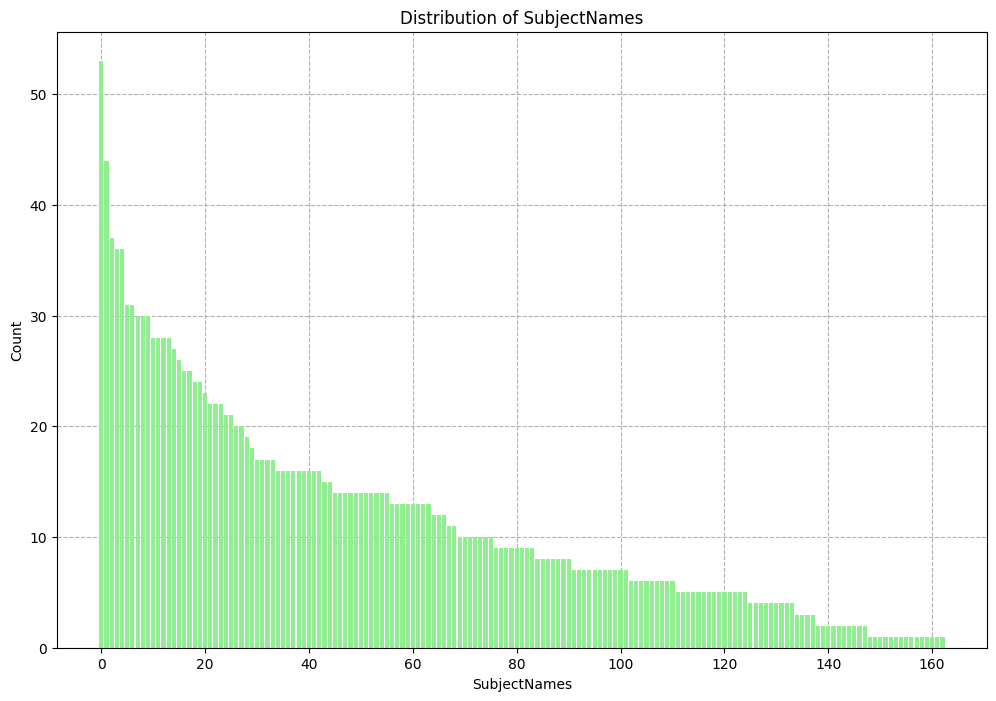

In [23]:
# overall frequency plot
plt.figure(figsize=(12,8))
plt.bar(subject_names.index, subject_counts, color='lightgreen', zorder=2)
plt.xlabel('SubjectNames')
plt.ylabel('Count')
plt.title('Distribution of SubjectNames')
plt.grid(ls='--')
plt.show()

## **MISCONCEPTIONS**

In [24]:
# Melt the misconception columns into a long format
misconceptions_long = train_data[['MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']].melt()

# Drop NaN values to get valid misconception IDs only
misconception_values = misconceptions_long['value'].dropna()

# Count occurrences of each misconception ID and reset the index to make it a DataFrame
misconception_names = misconception_values.value_counts().reset_index()
misconception_names.columns = ['MisconceptionId', 'count']

# Calculate the percentage of each misconception
misconception_names["Percentage"] = (misconception_names["count"] / misconception_names["count"].sum() * 100).round(2)

# Display the misconception counts table
display(misconception_names)

,MisconceptionId,count,Percentage
0,1214.0,54,1.24
1,1379.0,43,0.98
2,2316.0,38,0.87
3,1507.0,36,0.82
4,1990.0,33,0.76
...,...,...,...
1599,213.0,1,0.02
1600,2128.0,1,0.02
1601,1517.0,1,0.02
1602,2476.0,1,0.02


In [25]:
# Filter misconception that appear only once and get their count
number_of_single_occurrence_misconception = (misconception_names["count"] == 1).sum()

# Get the total number of distinct constructs
total_distinct_misconceptions = misconception_names.shape[0]

# Print the results
print(f"Number of misconceptions that appear only once: {number_of_single_occurrence_misconception}")
print(f"Total number of distinct misconceptions: {total_distinct_misconceptions}")

Number of misconceptions that appear only once: 747
Total number of distinct misconceptions: 1604


<ipython-input-37-67a11e8e2883>:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Count", y="MisconceptionId", data = top_30_misconceptions, palette="viridis", ci=None)
<ipython-input-37-67a11e8e2883>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Count", y="MisconceptionId", data = top_30_misconceptions, palette="viridis", ci=None)


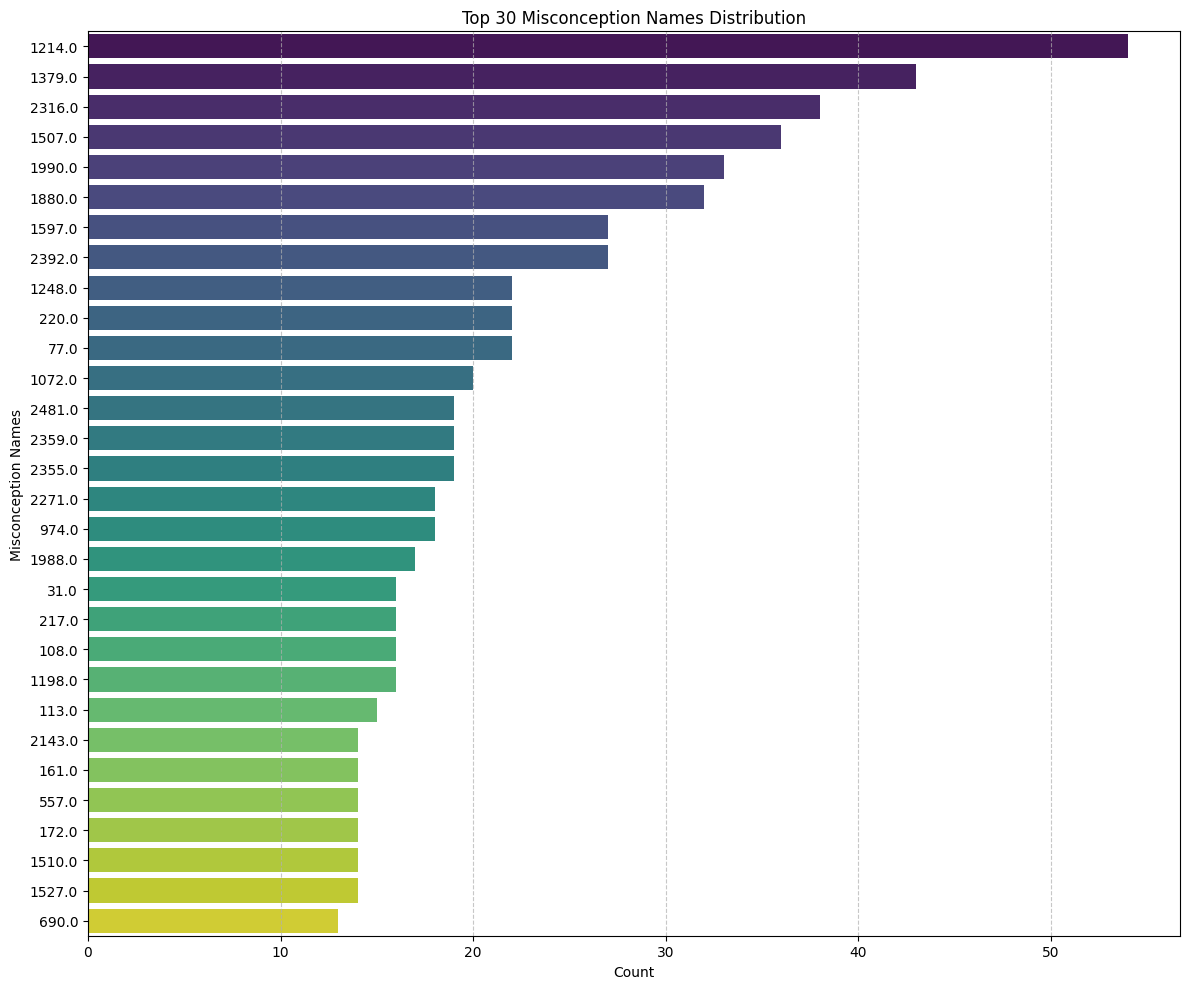

In [37]:
# Frequency distribution of the top 30 misconception_names

# Count occurrences of each misconception ID and reset the index
misconception_counts = misconception_values.value_counts().reset_index()
misconception_counts.columns = ['MisconceptionId', 'Count']

# Sort by count in descending order
misconception_counts = misconception_counts.sort_values(by="Count", ascending=False)

# Convert MisconceptionId to string for better label control
misconception_counts["MisconceptionId"] = misconception_counts["MisconceptionId"].astype(str)

# Plot the top 30 misconceptions
top_30_misconceptions = misconception_counts.head(30)
plt.figure(figsize=(12, 10))
sns.barplot(x="Count", y="MisconceptionId", data = top_30_misconceptions, palette="viridis", ci=None)
plt.title("Top 30 Misconception Names Distribution")
plt.xlabel("Count")
plt.ylabel("Misconception Names")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

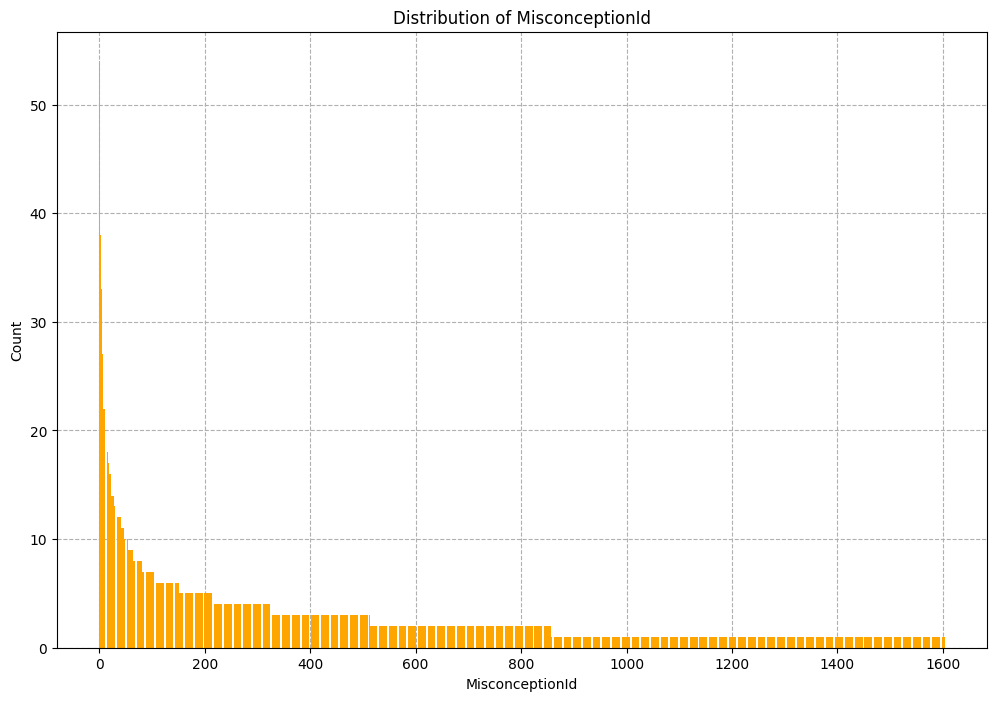

In [41]:
plt.figure(figsize=(12,8))
plt.bar(misconception_counts.index, misconception_counts['Count'], color='orange', zorder=2)
plt.xlabel('MisconceptionId')
plt.ylabel('Count')
plt.title('Distribution of MisconceptionId')
plt.grid(ls='--')
plt.show()

### **Take a look at the top 5 misconceptions and its corresponding ConstructName and SubjectName.**

<ipython-input-46-e16f42038ea5>:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


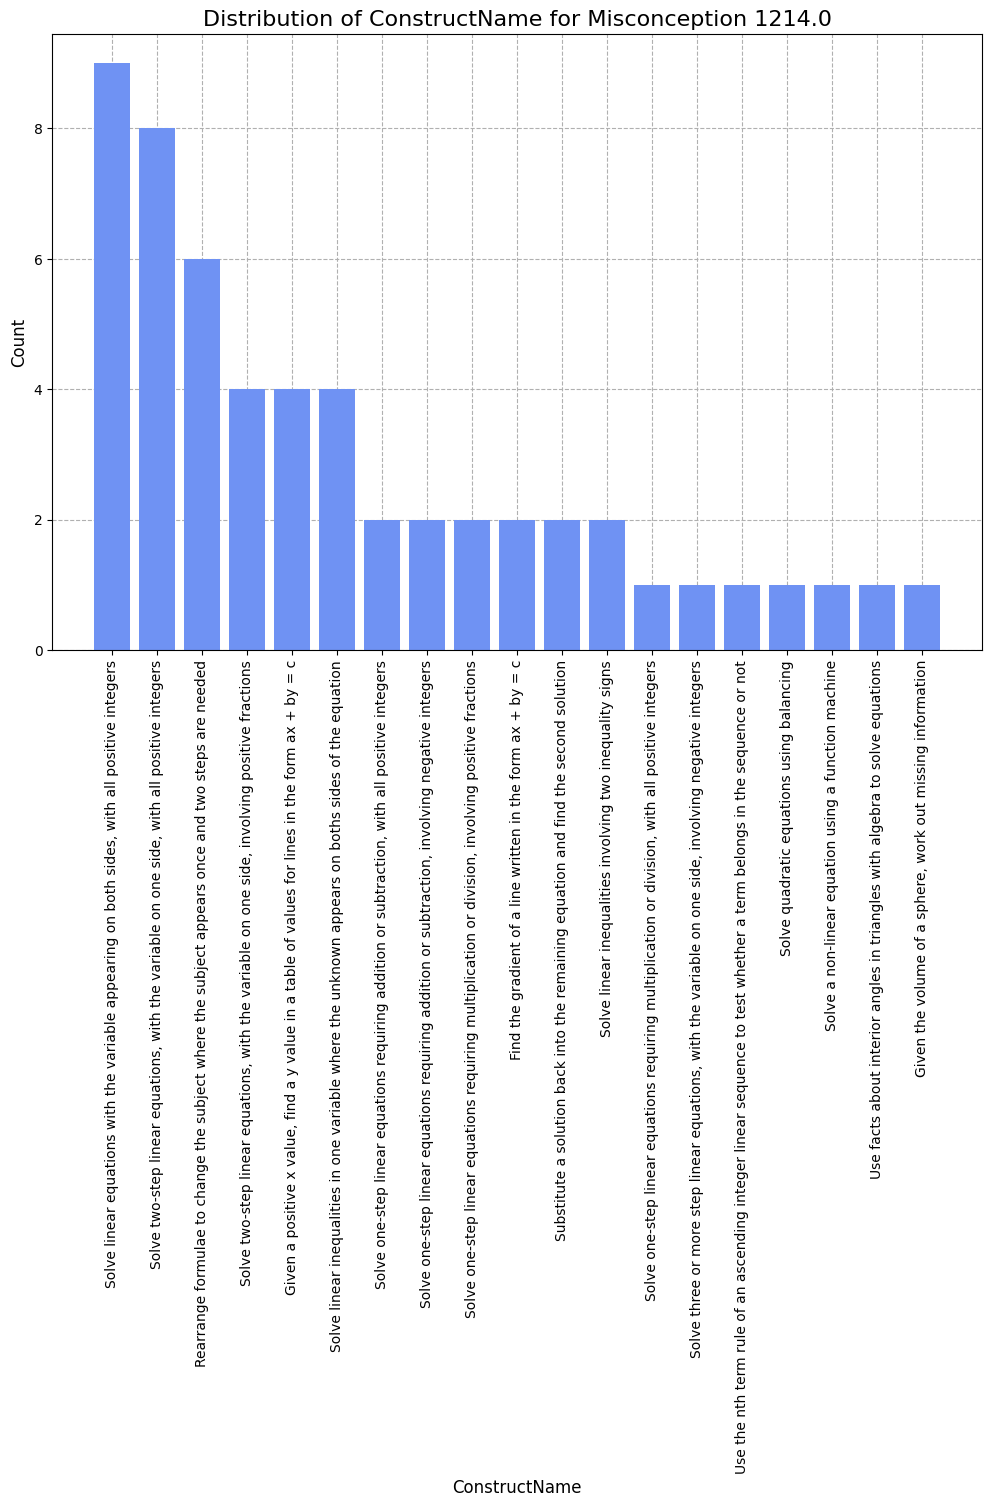

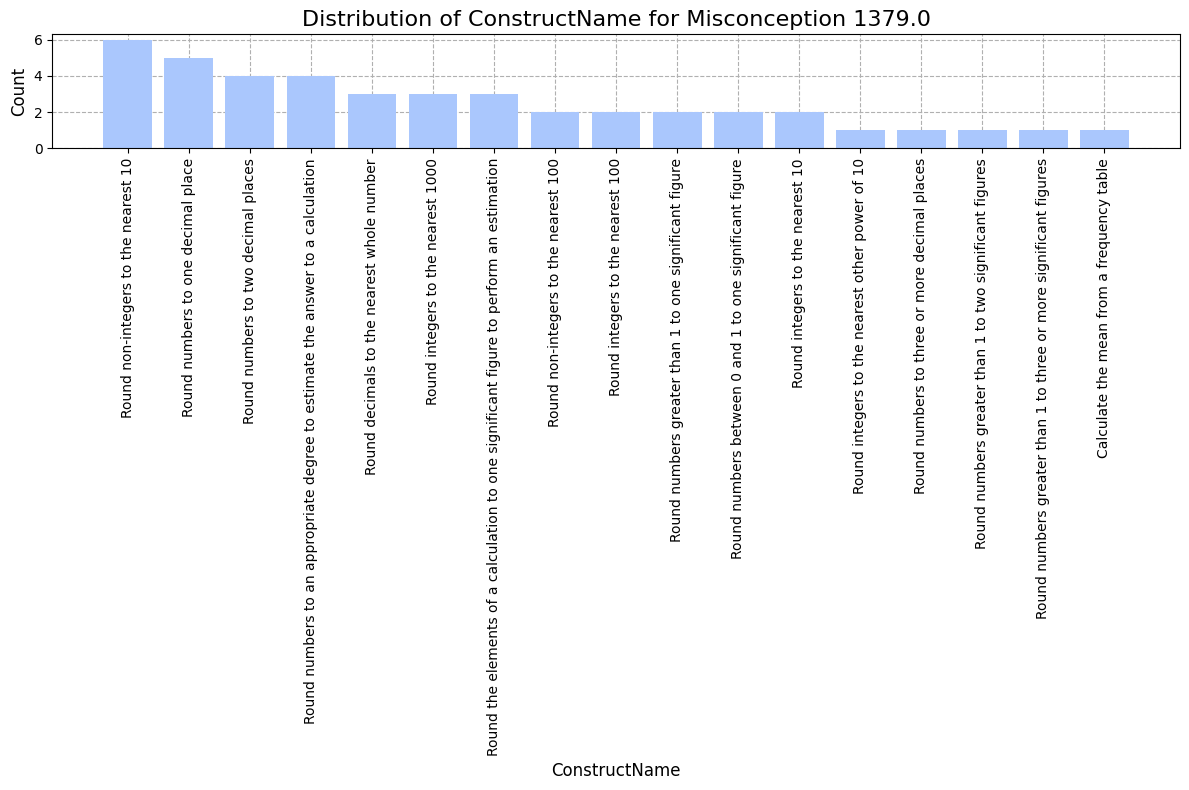

<ipython-input-46-e16f42038ea5>:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


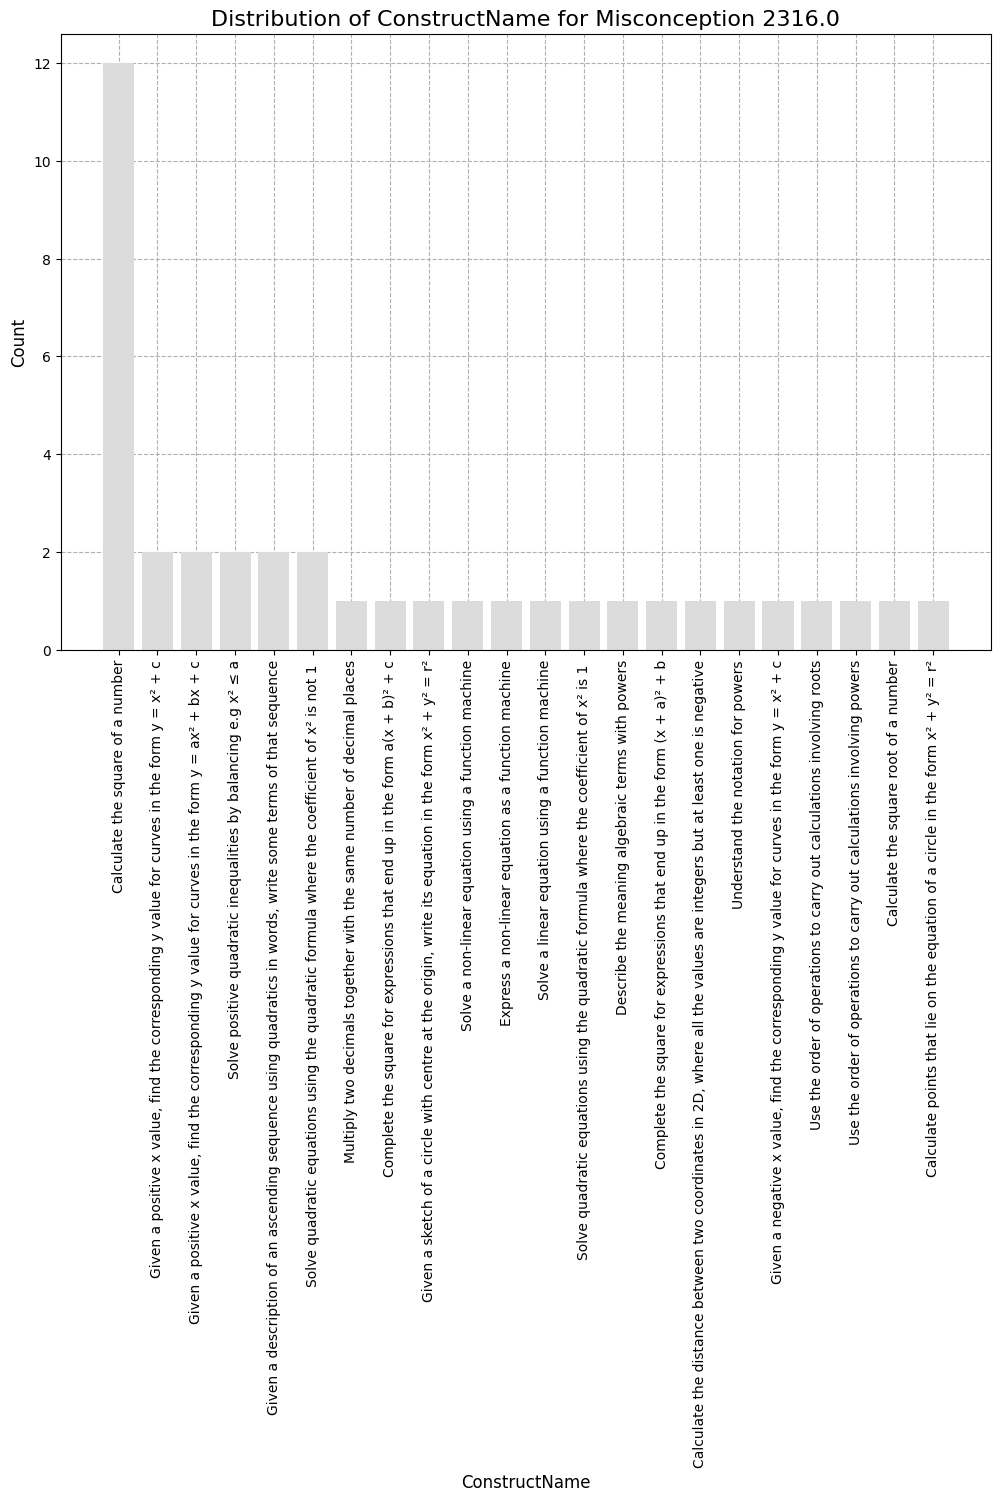

<ipython-input-46-e16f42038ea5>:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


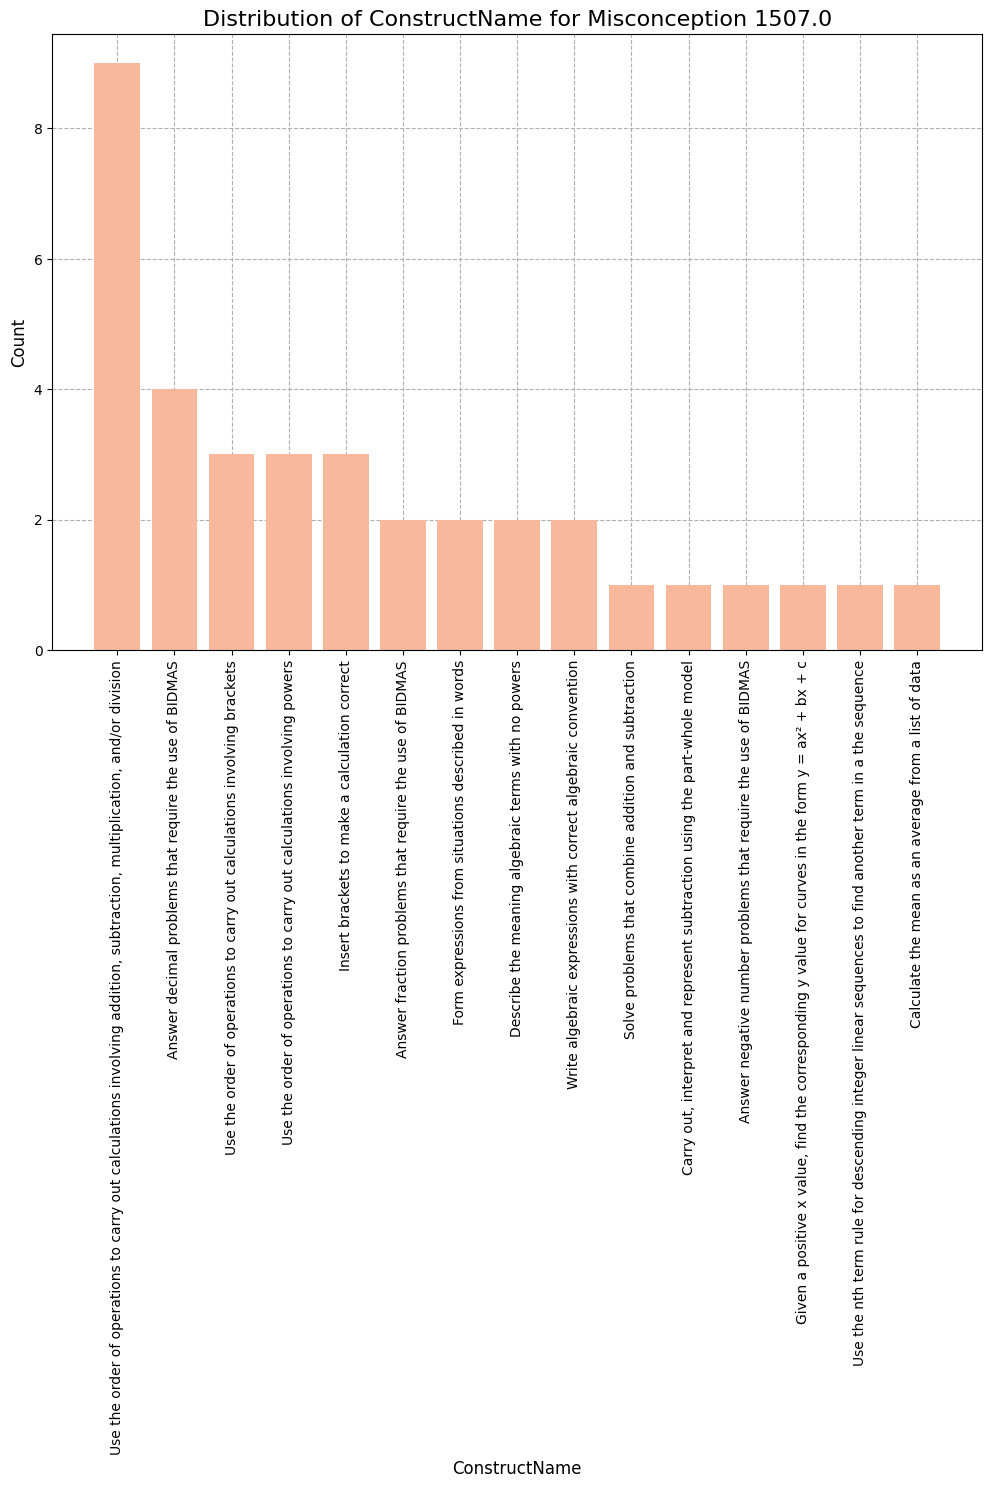

<ipython-input-46-e16f42038ea5>:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


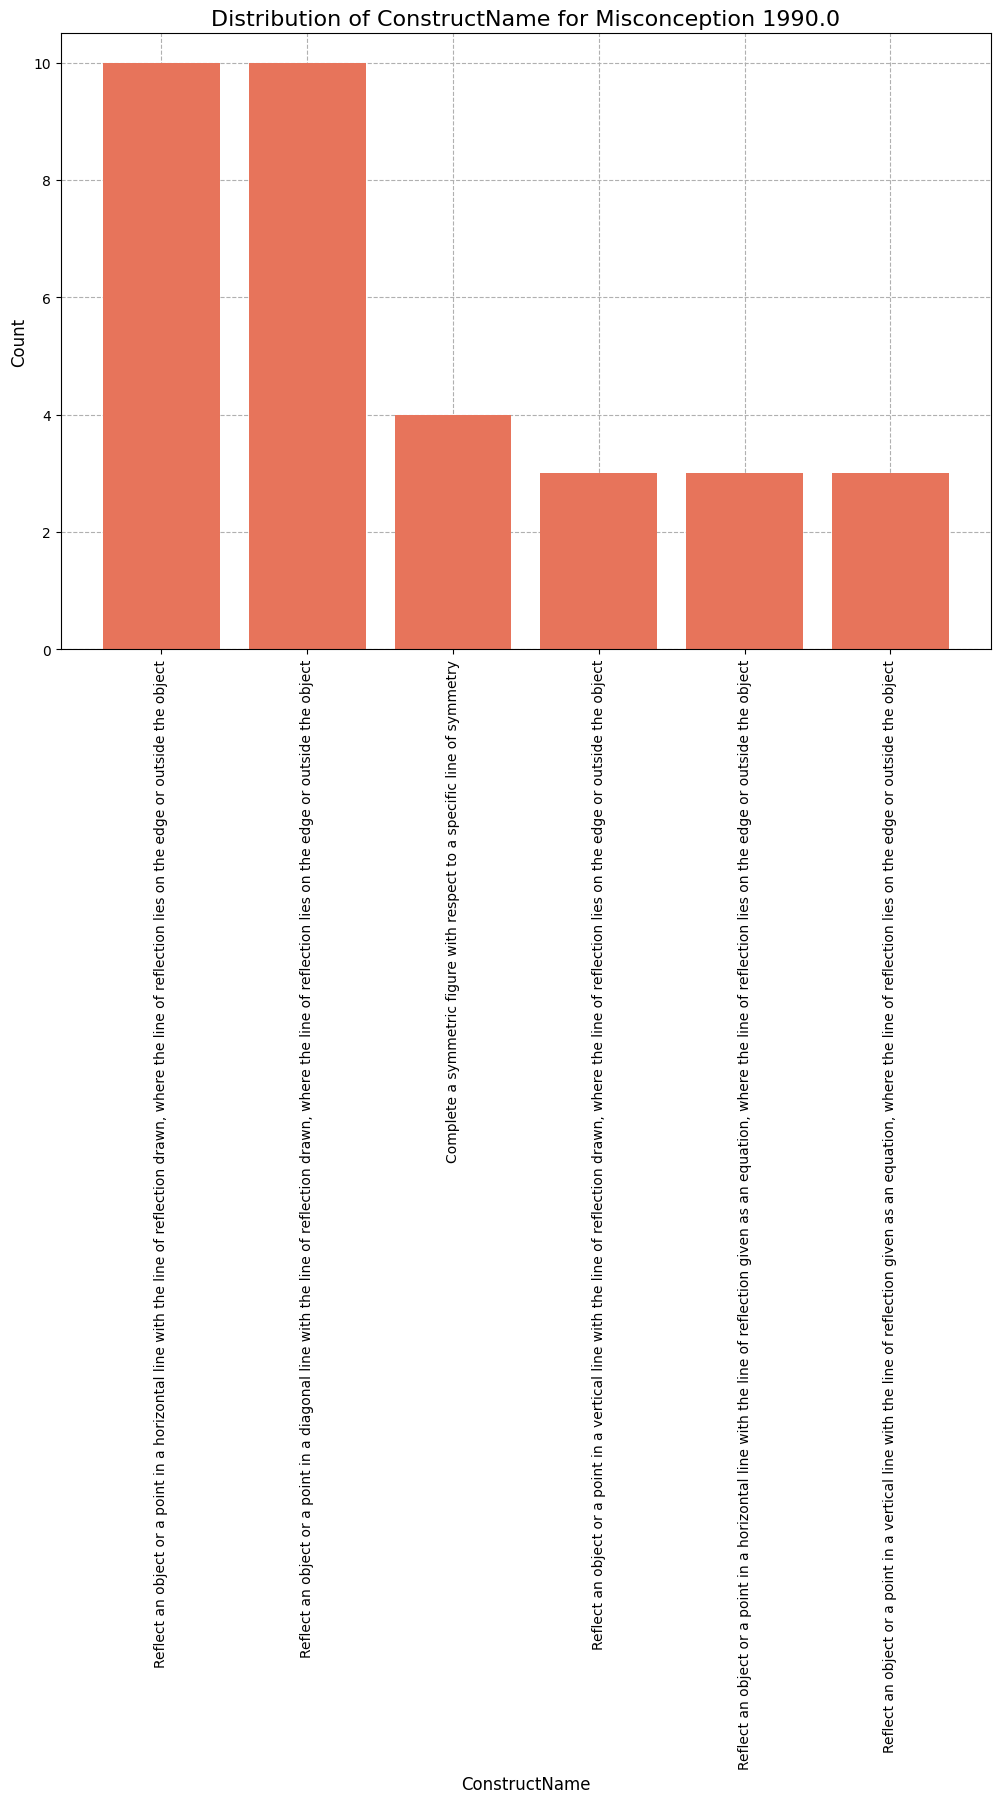

In [46]:
# Set a different color palette for each misconception plot
palette = sns.color_palette("coolwarm", 5)  # 5 colors for the top 5 misconceptions

# Loop through the top 5 misconceptions
for idx, misconception_id in enumerate(list(misconception_names[:5]['MisconceptionId'])):

    # Initialize a new Series to store counts for each ConstructId related to the current misconception
    construct_counts = pd.Series(dtype='int')

    # Accumulate counts of ConstructId for the specified misconception across all columns
    for name in ['MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']:
        temp_counts = train_data[train_data[name] == misconception_id]['ConstructId'].value_counts()
        construct_counts = construct_counts.add(temp_counts, fill_value=0)

    # Retrieve the ConstructName corresponding to each ConstructId (without modifying the original data)
    constructname_map = train_data[['ConstructId', 'ConstructName']].drop_duplicates().set_index('ConstructId')['ConstructName']
    construct_counts.index = construct_counts.index.map(constructname_map)  # Map ConstructId to ConstructName

    # Sort the construct_counts for clear visualization
    construct_counts = construct_counts.sort_values(ascending=False)

    # Plot the results
    plt.figure(figsize=(12, 8))
    plt.bar(construct_counts.index, construct_counts.values, color=palette[idx], zorder=2)  # Use dynamic color from palette
    plt.xlabel('ConstructName', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title(f'Distribution of ConstructName for Misconception {misconception_id}', fontsize=16)
    plt.grid(ls='--', zorder=1)  # Place gridlines behind the bars
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability
    plt.tight_layout()

    # Show the plot
    plt.show()

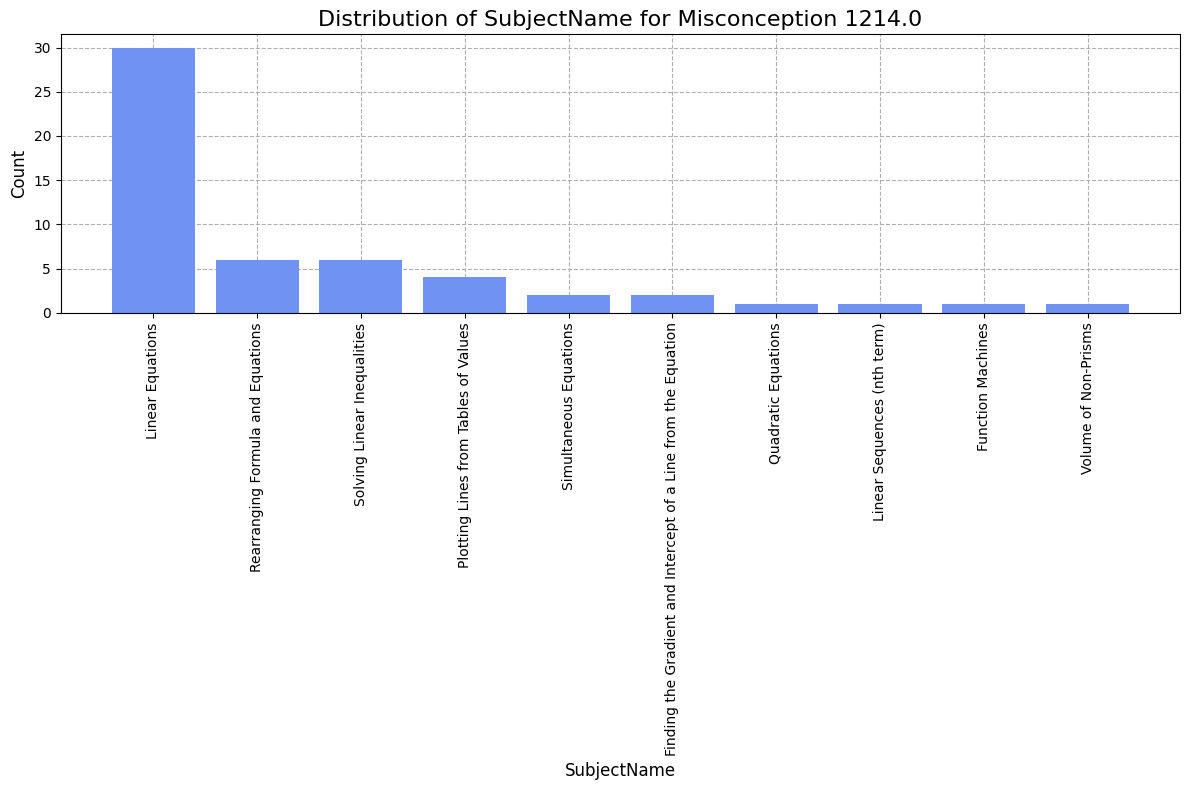

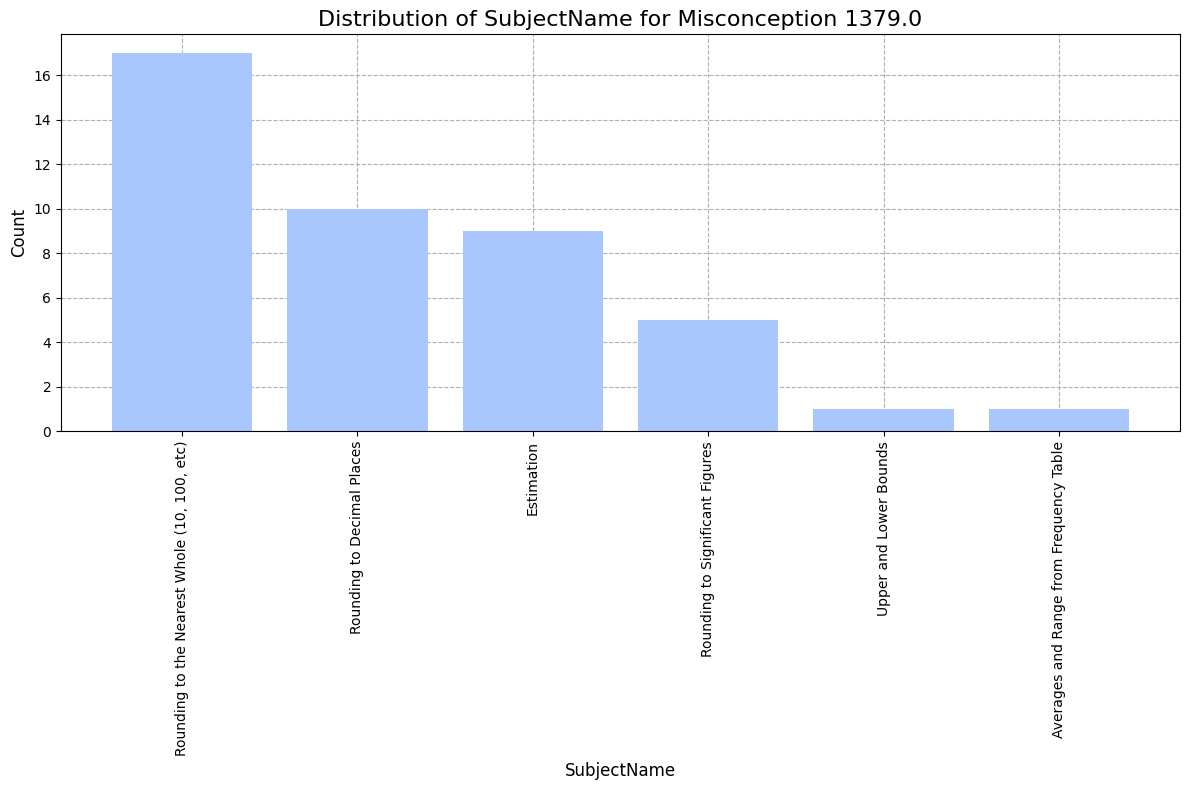

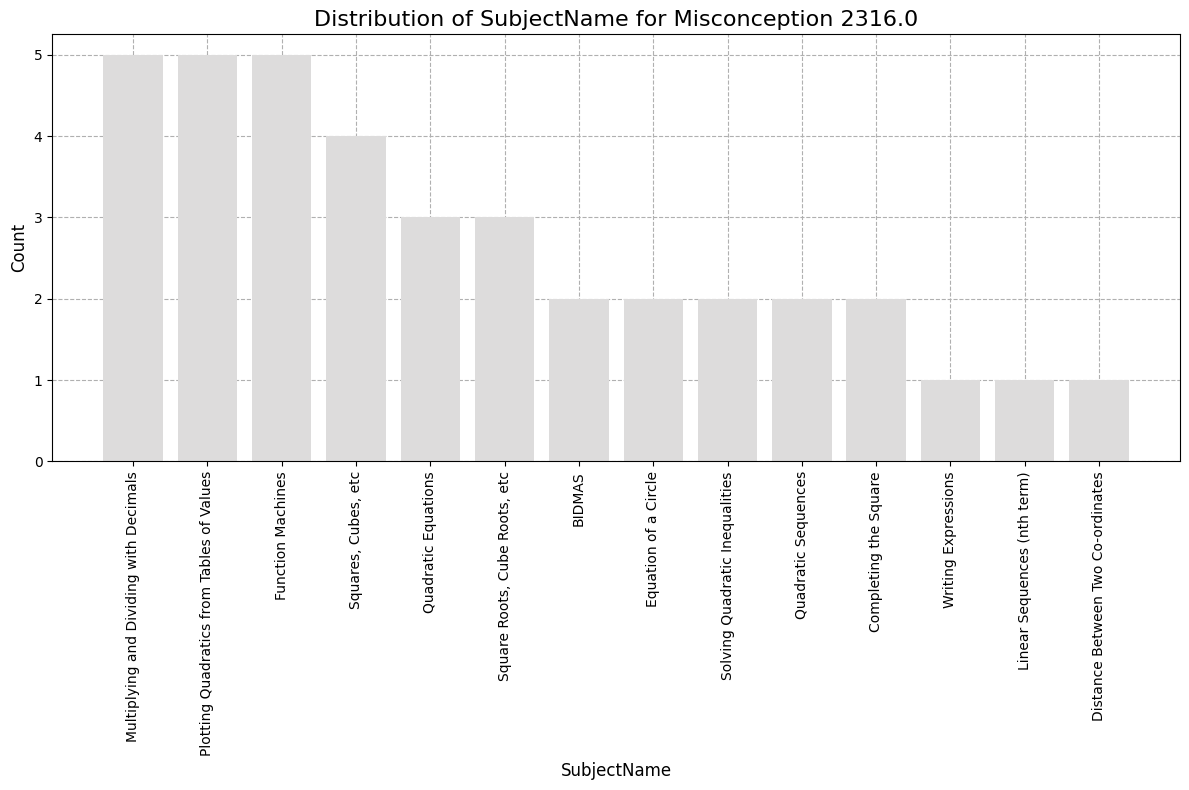

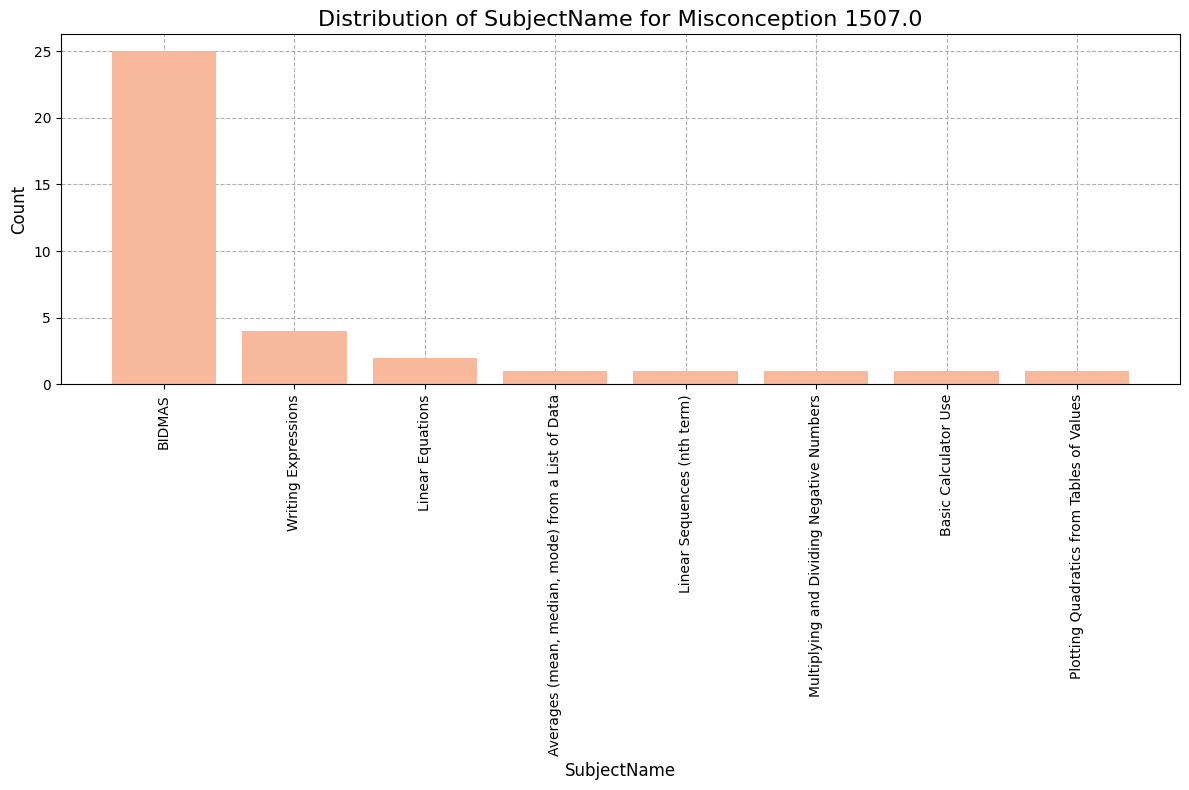

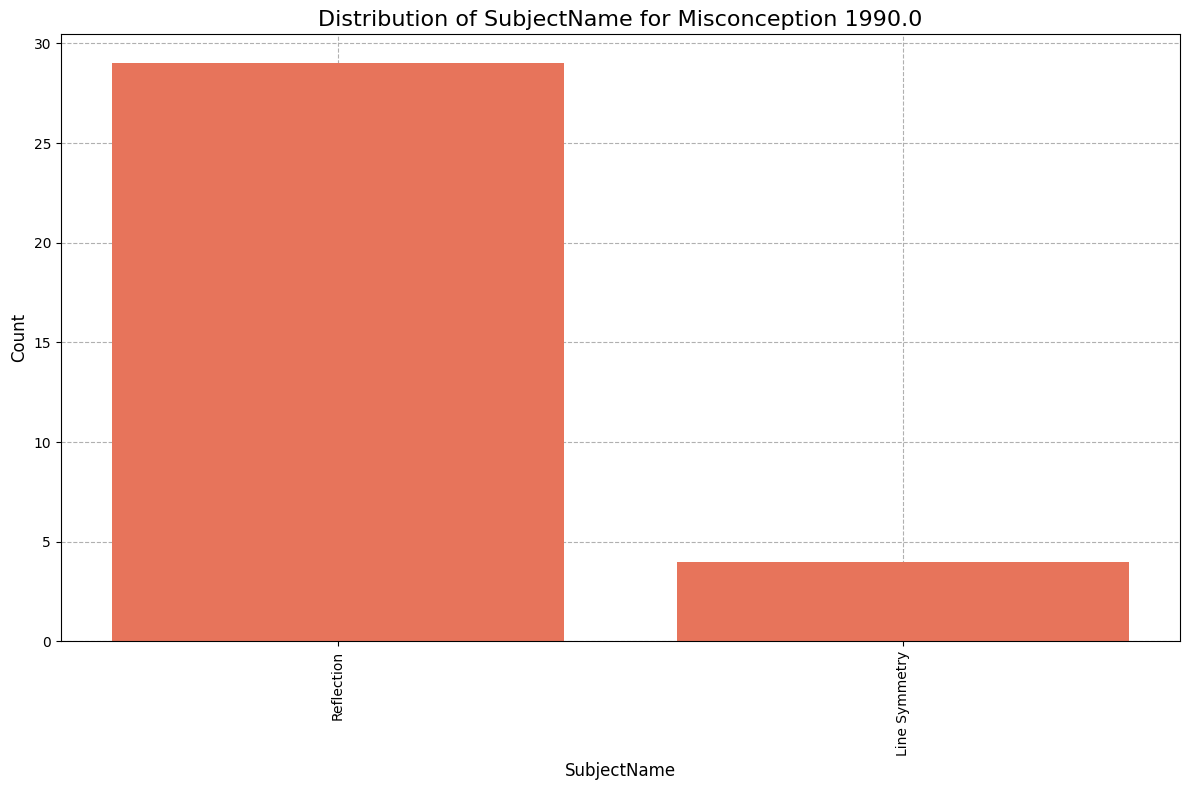

In [45]:
# Set a different color palette for each misconception plot
palette = sns.color_palette("coolwarm", 5)  # Change color scheme, 5 colors for top 5 misconceptions

# Loop through the top 5 misconceptions based on the specified MisconceptionId list
for idx, misconception_id in enumerate(list(misconception_names[:5]['MisconceptionId'])):

    # Initialize a new Series to store counts for each SubjectId related to the current misconception
    subject_counts = pd.Series(dtype='int')

    # Accumulate counts of SubjectId for the specified misconception across all columns
    for name in ['MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']:
        temp_counts = train_data[train_data[name] == misconception_id]['SubjectId'].value_counts()
        subject_counts = subject_counts.add(temp_counts, fill_value=0)

    # Retrieve the SubjectName corresponding to each SubjectId (without modifying the original data)
    subjectname_map = train_data[['SubjectId', 'SubjectName']].drop_duplicates().set_index('SubjectId')['SubjectName']
    subject_counts.index = subject_counts.index.map(subjectname_map)  # Map SubjectId to SubjectName

    # Sort the subject_counts for clear visualization
    subject_counts = subject_counts.sort_values(ascending=False)

    # Plot the results
    plt.figure(figsize=(12, 8))
    plt.bar(subject_counts.index, subject_counts.values, color=palette[idx], zorder=2)  # Use dynamic color from palette
    plt.xlabel('SubjectName', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title(f'Distribution of SubjectName for Misconception {misconception_id}', fontsize=16)
    plt.grid(ls='--', zorder=1)  # Place gridlines behind the bars
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability
    plt.tight_layout()

    # Show the plot
    plt.show()

# **Train.csv Insights from data exploration**

**1. Constructs Data Analysis**

- **Distribution of Constructs:**

 The frequency of certain constructs, like "Calculate the square of a number" and "Solve two-step linear equations," is significantly higher than others, indicating that these are more common or more frequently tested constructs.

  A large portion of the constructs in the dataset appears only once (imbalanced distribution), suggesting that there are many unique or rare constructs that may not be as prevalent in the dataset but could provide insights into less common areas of study or test difficulty.

- **Cumulative Percentage:**

  The cumulative percentage plot highlights that a small number of constructs account for a significant portion of the total occurrences, suggesting that the dataset might be biased towards certain types of mathematical concepts.

**2. Subjects Data Analysis**

- **Distribution of Subjects:**

  Common subjects such as "Linear Equations" and "Linear Sequences" dominate the dataset, while more niche subjects appear fewer times. This could suggest that the dataset is more focused on certain mathematical areas, likely the ones that are foundational for a broader set of students.

  Similar to ConstructNames, there are a significant number of subjects that occur only once (again a imbalanced distribution), which might indicate either very specific problems related to unique areas of study or less common subjects tested.

- **Cumulative Percentage:**

  The cumulative percentage for the top 20 subjects shows that a small proportion of subjects account for the majority of the data. This emphasizes the importance of focusing on the most common subjects when analyzing or building predictive models.

**3. Misconceptions Data Analysis**

- **Missing Misconceptions:**

  As we can see, there are lots of missing values for MisconceptionID. Some questions only give MisconceptionID for certain choices, while leave other MisconceptionID unknown.

- **Distribution of Misconceptions:**

  Misconceptions like "When solving an equation, uses the same operation rather than the inverse." (misconception 1214) and "Rounds down instead of up" (misconception 1379) are frequently observed, indicating that these misconceptions are common among students.

  A large number of misconceptions appear only once, suggesting that there are some very specific or rare misconceptions that might be less impactful but still present in the dataset.

- **Cumulative Percentage:**

  The cumulative percentage plot for misconceptions indicates that a small number of misconceptions account for a large portion of the data, similar to the distribution of constructs and subjects. This might help prioritize which misconceptions to focus on for educational interventions or model training.
